In [42]:
import pandas as pd
import mysql
from connect import DatabaseConnector

# 1. Total Views : from the Vendor Views logs Table We use the vendor_id to count the number views made

In [43]:
def get_vendor_Total_Views(user_id):
    
    db_connector = DatabaseConnector()  # Create an instance of DatabaseConnector
    # Connect to the database
    db_connector.connect_db()
    # Get the database connection
    connection = db_connector.get_connection()

    # If connection is not established, return
    if connection is None:
        print("No connection available to summarize the database.")
        return
    cursor = connection.cursor()

    try:
        # Execute the query to calculate the total count of the specified vendor_id
        query = f"""
            SELECT COUNT(*) AS count
            FROM vendor_view_logs
            WHERE vendor_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract count from the result tuple
        else:
            return 0  # If no rows are found, return count as 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [44]:
get_vendor_Total_Views(26)

Successfully connected to the database
Connection closed


623

In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
def plot_vendor_comparison(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve vendor counts.")
        return

    cursor = connection.cursor()

    try:
        # Get count for the specified vendor_id and all vendors
        query = """
            SELECT vendor_id, COUNT(*) AS total_views
            FROM vendor_view_logs
            GROUP BY vendor_id
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Create a DataFrame from the results
        df = pd.DataFrame(results, columns=['vendor_id', 'total_views'])

        # Get count for the specified vendor_id
        specified_vendor_count = df[df['vendor_id'] == vendor_id]['total_views'].values[0]

        # Get the vendor_id with the highest count
        highest_vendor_count = df['total_views'].max()

        # Get ranks
        df['rank'] = df['total_views'].rank(method='min', ascending=False)
        specified_vendor_rank = df[df['vendor_id'] == vendor_id]['rank'].values[0]
        highest_vendor_rank = df[df['total_views'] == highest_vendor_count]['rank'].values[0]

        # Plotting
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Specified Vendor', 'Highest Vendor'], [specified_vendor_count, highest_vendor_count], color=['skyblue', 'orange'])
        plt.xlabel('Vendor')
        plt.ylabel('Total Views')
        plt.title('Comparison of Specified Vendor vs Highest Vendor')

        # Add rank numbers at the top of each bar
        plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'Rank: {int(specified_vendor_rank)}', ha='center', va='bottom')
        plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'Rank: {int(highest_vendor_rank)}', ha='center', va='bottom')

        plt.show()
    except mysql.connector.Error as e:
        print(f"Error: {e}")
    finally:
        cursor.close()
        db_connector.close_connection()

# We can ranke our vendor produt views with the highest views

Successfully connected to the database


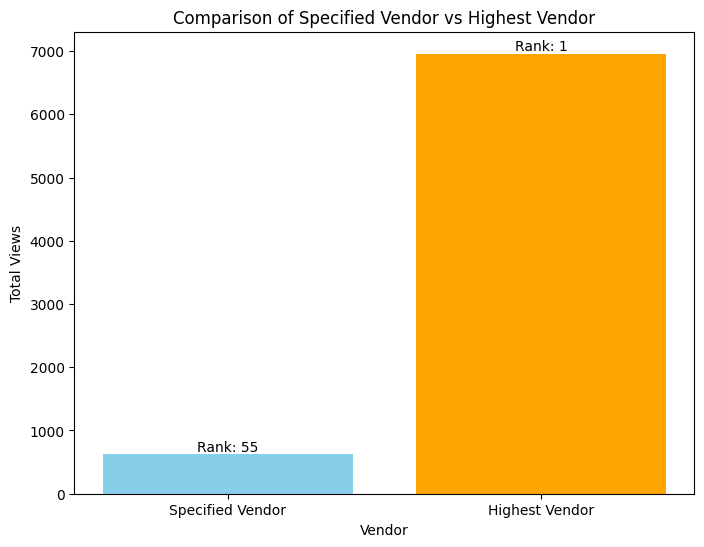

Connection closed


In [6]:
plot_vendor_comparison(268)

In [7]:
def is_vendor(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to check user type.")
        return False

    cursor = connection.cursor()

    try:
        # Query to check if the user is a vendor
        query = """
            SELECT type
            FROM users
            WHERE id = %s
        """
        cursor.execute(query, (user_id,))
        result = cursor.fetchone()

        if result and result[0] == 'vendor':
            return True
        else:
            return False
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return False
    finally:
        cursor.close()
        db_connector.close_connection()


# Example usage
user_id = 123  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 123 a vendor? True


In [8]:
# Example usage
user_id = 26  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 26 a vendor? True


# 2. Unique Customers Count based on the buy_logs, Products, and Vendor table

In [47]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT buy_logs.user_id) AS unique_customers_count
            FROM vendors
            JOIN products ON vendors.user_id = products.user_id
            JOIN buy_logs ON products.id = buy_logs.product_id
            WHERE vendors.user_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [48]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 268: 15


# 2.1 Optimized Unique Costomers Count based on the buy_logs, Products, and Vendor table

In [49]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Nested query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT user_id) AS unique_customers_count
            FROM buy_logs
            WHERE product_id IN (
                SELECT id
                FROM products
                WHERE user_id = (
                    SELECT user_id
                    FROM vendors
                    WHERE user_id = %s
                )
            )
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()


In [50]:

# Example usage
vendor_id = 268  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 268: 15


# 3. Number views Per Products  making use of View_product_logs

In [16]:
def get_product_views_count(product_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of views for the given product_id
        query = """
            SELECT COUNT(*) AS views_count
            FROM product_view_logs
            WHERE product_id = %s
        """
        cursor.execute(query, (product_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract views_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [17]:
# Example usage
product_id = 1  # Replace with the actual product ID
views_count = get_product_views_count(product_id)
print(f"Number of views for product ID {product_id}: {views_count}")

Successfully connected to the database
Connection closed
Number of views for product ID 1: 20


In [51]:
def get_vendor_product_views(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Step 1: Get all product IDs for the given vendor_id
        product_query = """
            SELECT id
            FROM products
            WHERE user_id = %s
        """
        cursor.execute(product_query, (vendor_id,))
        product_ids = cursor.fetchall()

        if not product_ids:
            print(f"No products found for vendor_id {vendor_id}")
            return None

        # Convert product_ids to a list
        product_ids = [product_id[0] for product_id in product_ids]

        # Step 2: Get the count of views for each product_id in the list using a single query
        format_ids = ','.join(map(str, product_ids))
        view_count_query = f"""
            SELECT product_id, COUNT(*) AS product_id_count
            FROM product_view_logs
            WHERE product_id IN ({format_ids})
            GROUP BY product_id
        """
        cursor.execute(view_count_query)
        view_counts = cursor.fetchall()

        # Create a dictionary from the view counts
        view_count_dict = {product_id: count for product_id, count in view_counts}

        # Step 3: Prepare the final data with all product_ids and their counts
        product_view_counts = [(product_id, view_count_dict.get(product_id, 0)) for product_id in product_ids]

        # Step 4: Create the DataFrame
        df_vendor_product_views = pd.DataFrame(product_view_counts, columns=['product_id', 'product_id_count'])

        return df_vendor_product_views
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [52]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views(vendor_id)
print(df_vendor_product_views)

Successfully connected to the database
Connection closed
    product_id  product_id_count
0          605               142
1          606               382
2          607               167
3         1272                66
4         1273                28
5         1274                20
6         1275                22
7         1276                22
8         1277                32
9         1278                28
10        1279                29
11        1280                94
12        1281                81
13       18743                 0
14       18744                 0
15       18745                 0
16       18746                 0
17       18747                 0
18       18748                 0
19       18749                 0
20       18750                 2
21       18751                 0
22       18752                 0
23       18753                 0
24       18754                 0
25       18905                 0
26       18906                 0
27       18907     

In [53]:
def get_vendor_product_views_and_plot(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Step 1: Get all product IDs and names for the given vendor_id
        product_query = """
            SELECT id, name
            FROM products
            WHERE user_id = %s
        """
        cursor.execute(product_query, (vendor_id,))
        products = cursor.fetchall()

        if not products:
            print(f"No products found for vendor_id {vendor_id}")
            return None

        # Convert products to a list of tuples
        product_data = [(product_id, product_name) for product_id, product_name in products]
        product_ids = [product_id for product_id, _ in products]

        # Step 2: Get the count of views for each product_id in the list using a single query
        format_ids = ','.join(map(str, product_ids))
        view_count_query = f"""
            SELECT product_id, COUNT(*) AS product_id_count
            FROM product_view_logs
            WHERE product_id IN ({format_ids})
            GROUP BY product_id
        """
        cursor.execute(view_count_query)
        view_counts = cursor.fetchall()

        # Create a dictionary from the view counts
        view_count_dict = {product_id: count for product_id, count in view_counts}

        # Step 3: Prepare the final data with all product_ids, their names, and their counts
        product_view_counts = [(product_id, product_name, view_count_dict.get(product_id, 0)) for product_id, product_name in product_data]

        # Step 4: Create the DataFrame
        df_vendor_product_views = pd.DataFrame(product_view_counts, columns=['product_id', 'product_name', 'product_id_count'])

        return df_vendor_product_views
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_dataframe(df):
    if df is not None and not df.empty:
        plt.figure(figsize=(14, 8))  # Increase the figure size
        plt.bar(df['product_name'], df['product_id_count'], color='blue')
        plt.xlabel('Product Name')
        plt.ylabel('View Count')
        plt.title(f'Product View Counts')
        plt.xticks(rotation=90)
        
        # Manually adjust the subplot parameters to give more room for the labels
        plt.subplots_adjust(bottom=0.3)  # Adjust the bottom margin
        
        plt.show()
    else:
        print("The DataFrame is empty or None.")

Successfully connected to the database
Connection closed


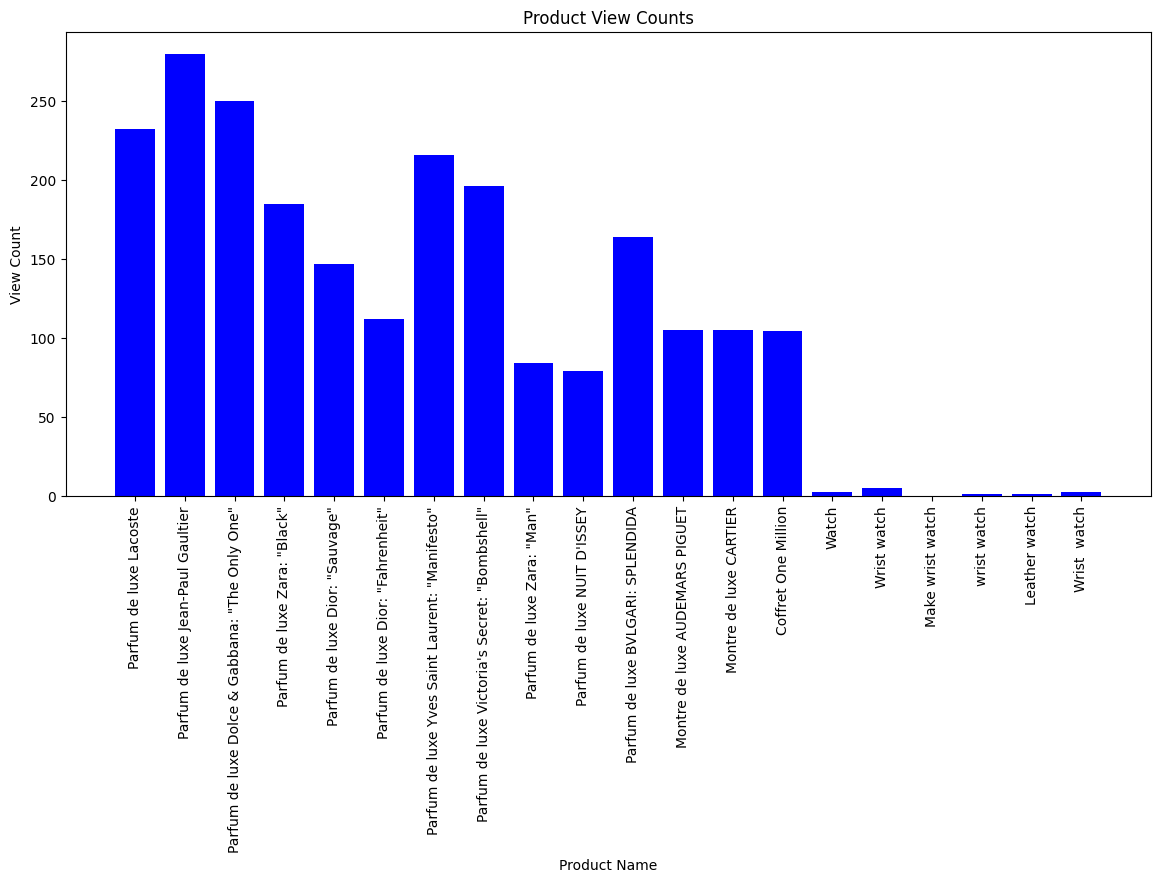

    product_id                                    product_name  \
0          468                          Parfum de luxe Lacoste   
1          469               Parfum de luxe Jean-Paul Gaultier   
2          474  Parfum de luxe Dolce & Gabbana: "The Only One"   
3          475                    Parfum de luxe Zara: "Black"   
4          476                  Parfum de luxe Dior: "Sauvage"   
5          478               Parfum de luxe Dior: "Fahrenheit"   
6          494  Parfum de luxe Yves Saint Laurent: "Manifesto"   
7          496   Parfum de luxe Victoria's Secret: "Bombshell"   
8          499                      Parfum de luxe Zara: "Man"   
9          504                     Parfum de luxe NUIT D'ISSEY   
10         506               Parfum de luxe BVLGARI: SPLENDIDA   
11         511                  Montre de luxe AUDEMARS PIGUET   
12         619                          Montre de luxe CARTIER   
13         620                          Montre de luxe CARTIER   
14        

In [54]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views_and_plot(vendor_id)
plot_dataframe(df_vendor_product_views)
print(df_vendor_product_views)

# Views Per Catigoury